# Klausur

## Imports

In [66]:
using CairoMakie
using FFTW
using LaTeXStrings
using Distributed
using ProgressMeter
using Profile

## Helper functions for integrator

In [67]:

"""
Computes gradient of a 2D scalar field.

`T` is a scalar field in fourier space.

Returns a vector field in direct space.
"""
function f_grad(T,Nx, Ny, Lx, Ly,dx,dy)

    kxf = Nx*fftfreq(Nx)*2*pi*im/Lx
    kyf = Ny*fftfreq(Ny)*2*pi*im/Ly

    dx = real(ifft(hcat((eachrow(T) .*kxf)...))')
    dy = real(ifft(hcat((eachcol(T) .*kyf)...)))

    return [dx,dy]
end


"""
Returns real fourier coeffs of v⋅∇T.

`v` is a vector field in direct space.

`T` is a scalar field in fourier space.

"""
function v∇T(v,T,Nx,Ny,Lx,Ly,dx,dy)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly,dx,dy)
    return fft(∇T[1].*v[1] .+ ∇T[2].*v[2])
end


"""
Time step for the integration of the temperature field.

`T` is the temperature field in fourier space.
 
`hat` and `hat_old` are the terms v∇T(n) and v∇T(n-1) in fourier space.

`Nx`, `Ny`, `Lx` and `Ly` are the number of modes and the length of the grid.

`ΔT` is the timestep.

`Q` is the source term.

Returns new temperature field in fourier space.
"""
function T_step(T,hat,hat_old,Nx,Ny,kx,ky,Δt,Q)
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T[i,j] = 1/(1+Δt*0.5*(kx[i]^2+ky[j]^2))*(T[i,j]+Δt*(-0.5*(kx[i]^2+ky[j]^2)*T[i,j]-0.5*(3*hat[i,j]-hat_old[i,j])+Q[i,j]))
        end
    end
    return T
end

"""
Updates the velocity field for a given `T` in fourier space.

`Ra` is the Rayleigh number.

Returns velocity vector field in fourier space. 
"""
function update_velocity(T,v,Nx,Ny,kx,ky,Ra)
    # Calculate matrix wich entries are the square of the length of k_ij #
    k_abs = kx.^2 .+ (ky.^2)'

    # Iterate over the velocity field and update each entry #
    # Set velocity to zero if k is zero #
    for i in 1:Nx
        for j in 1:Ny
            if k_abs[i,j] != 0
                v[1][i,j] = ((-kx[i]*ky[j]/k_abs[i,j])*T[i,j]*Ra)/(k_abs[i,j])
                v[2][i,j] = ((-ky[j]*ky[j]/k_abs[i,j] + 1)*T[i,j]*Ra)/(k_abs[i,j])
            else
                v[1][i,j] = 0.0
                v[2][i,j] = 0.0
            end
        end
    end

    # Perform reverse fourier transform on the vector field #
    v[1] = real(ifft(v[1]))
    v[2] = real(ifft(v[2]))
    return v
end


update_velocity

## Integrator

In [68]:
"""
Integrates the temperature field `T` with an initial velocity field `v` for `steps` steps with timestep `timestep`.

Returns an array containing saved temperature fields in fourier space.
"""
function integrate(geometry,timestep,steps,v,T,Q,dynamic=false,save_interval = 1,Ra=1,return_v=false)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]

    # Initialize matrices to store the differentiations of T #
    dx = zeros(ComplexF64,Nx,Ny)
    dy = zeros(ComplexF64,Nx,Ny)

    # Generate wave vectors #
    kx = 2*pi*fftfreq(Nx)*Nx/Lx
    ky = 2*pi*fftfreq(Ny)*Ny/Ly

    # Initialize arrays for the calculated temperature and velocity fields #
    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v)]
    T_new = fft(copy(T))
    
    # Calculate ℱ(v⋅∇T) #
    hat_old = v∇T(v_hist[end],T_hist[end - 1],Nx,Ny,Lx,Ly,dx,dy)
    T_old = fft(copy(T))

    # Integrate for `steps` steps #
    @showprogress for i in 1:steps

        # Calculate ℱ(v⋅∇T) #
        hat = v∇T(v,T_old,Nx,Ny,Lx,Ly,dx,dy)
        
        # Timestep for integration of T #
        T_new = T_step(T_old,hat,hat_old,Nx,Ny,kx,ky,timestep,Q)

        
        # Update variables #
        hat_old = copy(hat)
        T_old = T_new


        # Save a few temperature and velocity fields for plotting etc. #
        if i % (save_interval) == 0
            push!(T_hist,copy(T_new))
            push!(v_hist,copy(v))
        end

        # Update velocity field # 
        if dynamic
            v = copy(update_velocity(T_new,v,Nx,Ny,kx,ky,Ra))
        end

    end

    if !return_v
        return T_hist
    else
        return T_hist, v_hist
    end
end

integrate

## Test functions and functions for analysis

In [69]:
"Calculates the sum of the elementwise absolute diffrence between two scalar fields"
function abs_change(a,b)
    diff = a - b
    change = sum(abs.(diff))
    return change
end

"Initial velocity vector field"
function test_velocity(Nx,Ny,Lx,Ly)
    v = Vector{Matrix{Float64}}
    v = [zeros(Float64,Nx,Ny),zeros(Float64,Nx,Ny)]
    for i in 1:Nx
        for j in 1:Ny
            v[1][i,j] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
            v[2][i,j] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
        end
    end
    return v
end

"Test source term Q in fourier space"
function test_source(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            x = Lx/Nx*i
            y = Ly/Ny*j
            Q[i,j] = -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 8*pi^2*cos(2*pi*x)*sin(2*pi*y)
        end
    end
    return fft(Q)
end

"""
Gauss source term with width `σ`.

Returns `Q` in fourier space.
"""
function gauss_source(Nx,Ny,Lx,Ly,σ)
    Q = fill(0.0,Nx,Ny)
   
    for i in 1:Nx
        for j in 1:Ny
            x = Lx/Nx * i
            y = Ly/Ny * j
            Q[i,j] = 1/(2*pi*σ^2)*exp(-((x-0.5*Lx)^2 + y^2)/(2*σ^2))
        end
    end
    return fft(Q) 
end


"""
Finds the position of the plume head by going from top to bottom on the temperature field
and checking if the temperature is above 0.001.
"""
function plume_velocity(T_direct,Nx,Ny)
    offset = floor(Int64,Ny/10)
    middle = floor(Int64,Nx/2)
    for i in 1:(Ny - offset)
        temp = T_direct[middle,Ny - i - offset + 1]
        if temp > 0.001
            return Ny - i - offset
        end
    end
    return 0
end

"Returns T* in direct space."
function target_T(Nx,Ny,Lx,Ly)
    target = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
        end
    end
    return target
end

target_T

## Task 5

In [148]:
function test_function(plot_mode,geometry,timestep,steps,Q_mode="test",v_mode="test",Ra=1.0,σ=0.01)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]
    
    # Initial temperature field #
    T = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            T[i,j] = 0
        end
    end

    # Source term#
    Q = gauss_source(Nx,Ny,Lx,Ly,σ)
    if Q_mode == "test"
        Q = test_source(Nx,Ny,Lx,Ly)
        display(print("test"))
    end

    # Initial velocity field #
    v = Vector{Matrix{ComplexF64}}(undef, 2)
    if v_mode == "test"
        v = test_velocity(Nx,Ny,Lx,Ly)
    else
        display(print("Zero"))
        v[1] = zeros(ComplexF64,Nx,Ny)
        v[2] = zeros(ComplexF64,Nx,Ny)
    end

    # Plot maximum temperature to find stationaty solution #
    if plot_mode == "max"
        maxx = []
        for h in integrate(geometry,timestep,steps,v,T,Q)
            append!(maxx,maximum(real(ifft(h))))
        end
        display(plot(maxx))
    end
    
    # Plot velocity for task 5 #
    if plot_mode == "v"
        f = Figure()
        ax_1 = Axis(f[1, 1],title = L"$x$ componet of velocity field $\vec{v}^*$",xlabel = L"x",ylabel = L"y",aspect = 1)
        ax_2 = Axis(f[1, 2],title = L"$y$ componet of velocity field $\vec{v}^*$",xlabel = L"x",ylabel = L"y",aspect = 1)
        joint_limits = (-5,5)
        plotx = CairoMakie.heatmap!(ax_1,(0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),v[1],colorrange = joint_limits,colormap=:magma)
        ploty = CairoMakie.heatmap!(ax_2,(0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),v[2],colorrange = joint_limits,colormap=:magma)
        Colorbar(f[:, 3], colorrange = joint_limits,colormap=:magma)
        rowsize!(f.layout, 1, Aspect(1, 1))
        resize_to_layout!(f)

        display(f)
        save("task4_velocity_field.pdf",f)
    end

    # Plot Source term Q #
    if plot_mode == "Q"
        f = Figure()
        ax = Axis(f[1, 1],xlabel = L"x",ylabel = L"y",aspect = 1)
        hm = CairoMakie.heatmap!(ax,(0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),real(ifft(Q)),colormap=:magma)
        Colorbar(f[:, end+1], hm)
        Label(f[0, :], text = L"Source Term $Q^*", textsize = 25)
        colsize!(f.layout, 1, Aspect(2, 1))
        resize_to_layout!(f)
        display(f)
        save("Q_star.pdf",f)
        print(maximum(T))

    end

    # Plot T for task 4 #
    if plot_mode == "final"
        f = Figure()
        ax = Axis(f[1, 1],xlabel = L"x",ylabel = L"y",aspect = 1 )
        
        T = real(ifft(integrate(geometry,timestep,steps,v,T,Q)[end]))
        hm = CairoMakie.heatmap!(ax,(0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),T,title=L"$T$ after " * string(steps) * " time steps",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",colormap=:magma)
        Colorbar(f[:, end+1], hm)
        
        Label(f[0, :], text = L"$T$ after %$(steps) timesteps and a $\Delta t$ of %$(timestep)", textsize = 25)
        colsize!(f.layout, 1, Aspect(2, 1))
        resize_to_layout!(f)
        
        
        display(f)
        save("Task5_T.pdf",f)
        print(maximum(T))
    end

    # Plot difference between T and T* #
    if plot_mode == "test"
        f = Figure()
        ax = Axis(f[1, 1],aspect = Nx/Ny,xlabel = L"x",ylabel = L"y")
        xs = 1:Nx
        ys = 1:Ny
        T = real(ifft(integrate(geometry,timestep,steps,v,T,Q)[end]))
        hm = CairoMakie.heatmap!(ax,target_T(Nx,Ny,Lx,Ly) - T,colormap=:magma)
        Colorbar(f[:, end+1], hm)
        
        Label(f[0, :], text = L"$T^* - T$ after %$(steps) timesteps, $Δt = $ %$(timestep)", textsize = 25)
        colsize!(f.layout, 1, Aspect(2, 1))
        resize_to_layout!(f)
        display(f)
        save("task5_diff.pdf",f)
        print(sum(abs.(target_T(Nx,Ny,Lx,Ly) - T)))
    end

    # Plot T* #
    if plot_mode == "target"
        f = Figure()
        ax = Axis(f[1, 1], aspect = Nx/Ny,xlabel = L"x", ylabel = L"y")
        xs = 1:Nx
        ys = 1:Ny
        hm = CairoMakie.heatmap!(ax,xs*Lx/Nx,ys*Ly/Ny,target_T(Nx,Ny,Lx,Ly),colormap=:magma)
        Colorbar(f[:, end+1], hm)
        
        Label(f[0, :], text = L"Temperature field $T^*$", textsize = 25)
        colsize!(f.layout, 1, Aspect(2, 1))
        resize_to_layout!(f)
        display(f)
        save("t_star.pdf",f)
    end

    # Test velocity integration #
    if plot_mode == "testVelocity"
        Nx = 32
        Ny = 32
        Lx = 1.0
        Ly = 1.0
        kx = 2*pi*fftfreq(Nx)*Nx/Lx
        ky = 2*pi*fftfreq(Ny)*Ny/Ly
        v = Vector{Matrix{ComplexF64}}(undef, 2)
        v[1] = zeros(ComplexF64,Nx,Ny)
        v[2] = zeros(ComplexF64,Nx,Ny)
        v = update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),v,Nx,Ny,kx,ky,Ra)
        vx = v[1]
        vy = v[2]
        
        xs = 1:Nx
        ys = 1:Ny
        
        xxs = [x for x in xs for y in ys]
        yys = [y for x in xs for y in ys]

        f = Figure()
        ax = Axis(f[1, 1],xlabel = L"x",ylabel = L"y",aspect = 1)
        
        hm = CairoMakie.heatmap!(ax,xs*Lx/Nx,ys*Ly/Ny,target_T(Nx,Ny,Lx,Ly),colormap=:magma)

        sp = CairoMakie.quiver!(ax,xs*Lx/Nx,ys*Ly/Ny,vx,vy, lengthscale = 5,color=:gray40)
        Colorbar(f[:, end+1], hm)

        Label(f[0, :], text = L"Temperature field $T^*$ and velocity field $\vec{v}$", textsize = 25)
        colsize!(f.layout, 1, Aspect(2, 1))
        resize_to_layout!(f)
        display(f)
        save("test_velocity_update.pdf",f)
    end

    # Task 9 #
    if plot_mode == "task9"
        f = Figure()
        Ts, vs = integrate(geometry,timestep,steps,v,T,Q,true,steps/4,Ra,true)
        for i in 3:length(Ts)
            time = round(steps/4*(i-2)*timestep,digits=8)
            ax = Axis(f[1, i-2],aspect = Nx/Ny,title = L"t=%$(time)",xticklabelrotation = pi/2,xticks = [0,Lx])
            xs = 0:(Lx/Nx):Lx
            ys = 0:(Ly/Ny):Ly
            T_direct = real(ifft(Ts[i]))
            hm = CairoMakie.heatmap!(ax,xs,ys,T_direct,colormap=:magma)
            ps = plume_velocity(T_direct,Nx,Ny)
            CairoMakie.hlines!(ax,ys[ps],color=:white)
        end

        Colorbar(f[:, end+1], hm)
        Label(f[0, :], text = L"Temperature field $T$ at diffrent times with $\Delta t=$ %$(timestep), $Ra=$ %$(Ra)", textsize = 25)
        display(f)
        save("task9_test.pdf",f)
    end

    # Task 7 #
    if plot_mode == "task7"
        joint_limits = (0,0.01)
        x_lim = (-600,600)
        y_lim = (-2000,2000)
        Ts, vs = integrate(geometry,timestep,steps,v,T,Q,true,steps/4,Ra,true)
            f = Figure()
            time = round(steps*timestep,digits=8)
            ax_T = Axis(f[1, 1],aspect = Nx/Ny,title = L"$T$",xticklabelrotation = pi/2,xticks = [0,Lx])
            ax_x = Axis(f[1, 3],aspect = Nx/Ny,title = L"$\vec{v}_x$",xticklabelrotation = pi/2,xticks = [0,Lx])
            ax_y = Axis(f[1, 5],aspect = Nx/Ny,title = L"$\vec{v}_y$",xticklabelrotation = pi/2,xticks = [0,Lx])

            xs = 0:(Lx/Nx):Lx
            ys = 0:(Ly/Ny):Ly
            T_direct = real(ifft(Ts[end]))
            hm_t = CairoMakie.heatmap!(ax_T,xs,ys,T_direct,colormap=:magma,colorrange=joint_limits)
            hm_x = CairoMakie.heatmap!(ax_x,xs,ys,real(ifft(vs[end][1])),colormap=:magma,colorrange=x_lim)
            hm_y = CairoMakie.heatmap!(ax_y,xs,ys,real(ifft(vs[end][2])),colormap=:magma,colorrange=y_lim)
            Label(f[0, :], text = L"$T$ and $\vec{v}$ at $t=$ %$(time) with $\Delta t=$ %$(timestep), $Ra=$ %$(Ra)", textsize = 25)
            Colorbar(f[1, 2],colorrange=joint_limits,colormap=:magma)
            Colorbar(f[1, 4],colorrange=x_lim,colormap=:magma)
            Colorbar(f[1, 6],colorrange=y_lim,colormap=:magma)
            display(f)
            save("task7_with_velocity_$(time)_$(Ra).pdf",f)
    end

    # Test stability for different resolution #
    if plot_mode == "task4_stability"
        resolutions = [8,16,32,64,128]
        for r in resolutions
            geometry = ((r,r),(1.0,1.0))
            Nx = r
            Ny = r
            target = target_T(Nx,Ny,Lx,Ly)
            stable = true
            timestep = 0.1
            first = timestep
            iterations = 20
            t_max = 5.0
            step_max = 1000
            max_step = 1e-1
            iterations = 10
            cutof = 1e-5
            stable = true
            while stable
                T = fill(0.0, (Nx,Ny))
                for i in 1:Nx
                    for j in 1:Ny
                        T[i,j] = 0
                    end
                end
                Q = gauss_source(Nx,Ny,Lx,Ly,σ)
                if Q_mode == "test"
                    Q = test_source(Nx,Ny,Lx,Ly)
                end
                v = Vector{Matrix{ComplexF64}}(undef, 2)
                if v_mode == "test"
                    v = test_velocity(Nx,Ny,Lx,Ly)
                else
                    v[1] = zeros(ComplexF64,Nx,Ny)
                    v[2] = zeros(ComplexF64,Nx,Ny)
                end
                T = real(ifft(integrate(geometry,timestep,t_max/timestep,v,T,Q)[end - 1]))
                dif = sum(abs.(target - T))

                if dif > cutof || isnan(dif) || isinf(dif)
                    timestep -= 0.001
                else
                    display(print("Resolution $(r) | Last stable dt =  $(timestep + 0.001)"))
                    break
                end
                if timestep < 0
                    print("error")
                    break
                end
            end
        end

    end

    # Measure plume velocity #
    if plot_mode == "plume_v"
        f = Figure()
        ax = Axis(f[1, 1],xlabel = L"Time $t$",
        ylabel = L"Position$$",)
        rayleigh = [1e7,1e8,1e9,1e10]
        timesteps = [1e-7,1e-7,1e-7,5e-8,5e-8,1e-8]
        tss = 5e-8
        t_max = 1e-5
        steppss = 1000
        for (r,ts) in zip(rayleigh,timesteps)
            #print(floor(t_max/ts))
            Ts, vs = integrate(geometry,tss,steppss,v,T,Q,true,steppss/8,r,true)
            #print(Ts)
            positions = []
            times = []
            for i in 3:length(Ts)
                time = round(steppss/8*(i-2)*tss,digits=8)
                print(time)
                xs = 0:(Lx/Nx):Lx
                ys = 0:(Ly/Ny):Ly
                T_direct = real(ifft(Ts[i]))
                ps = plume_velocity(T_direct,Nx,Ny)
                push!(positions,ps*Ly/Ny)
                push!(times,time)
            end
            print(positions)
            print(times)
            CairoMakie.scatter!(ax,copy(float.(copy(times))),copy(float.(copy(positions))),label=L"%$(r)",marker = :cross) 
        end
        f[1,2] = Legend(f,ax,L"Rayleigh number $$")
        Label(f[0, :], text = L"Position of the plume head for different Rayleigh numbers.$$", textsize = 25)
        display(f)
        save("plume_velocity.pdf",f)
    end

Nx = 8
Ny = 8
Lx = 1.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 0.03
steps = 5000

#test_function("final",geometry,0.001,500)
#test_function("test",geometry,0.031,500)
#test_function("roc",geometry,0.001,400)

Nx = 64
Ny = 8*Nx
Lx = 1.0/8.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 5e-8
steps = 10000

#test_function("task9",geometry,timestep,steps,"gauss","zero",5e9,0.01)
#test_function("task7",geometry,timestep,steps,"gauss","zero",1e10,0.01)
#test_function("plume_v",geometry,timestep,steps,"gauss","zero",1e10,0.01)

Nx = 64
Ny = 64
Lx = 1.0
Ly = 1.0
geometry = ((Nx,Ny),(Lx,Ly))
#test_function("Q",geometry,timestep,steps,"test","test")
#test_function("v",geometry,timestep,steps,"test","test")
#test_function("testVelocity",geometry,timestep,steps)
#test_function("target",geometry,timestep,steps)
#test_function("task4_stability",geometry,timestep,steps)

#test_function("task4_stability",geometry,timestep,steps)

############# TODO k = 0
####### Why 4 more stable

Zero

nothing

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Res 8, Ra 100000.0, TS 1.0

nothing

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

LoadError: InterruptException:

## Task 6

In [6]:
history = Vector{Matrix{ComplexF64}}
push!(history, neu)
history[end][1,2]

test_v_update (generic function with 1 method)

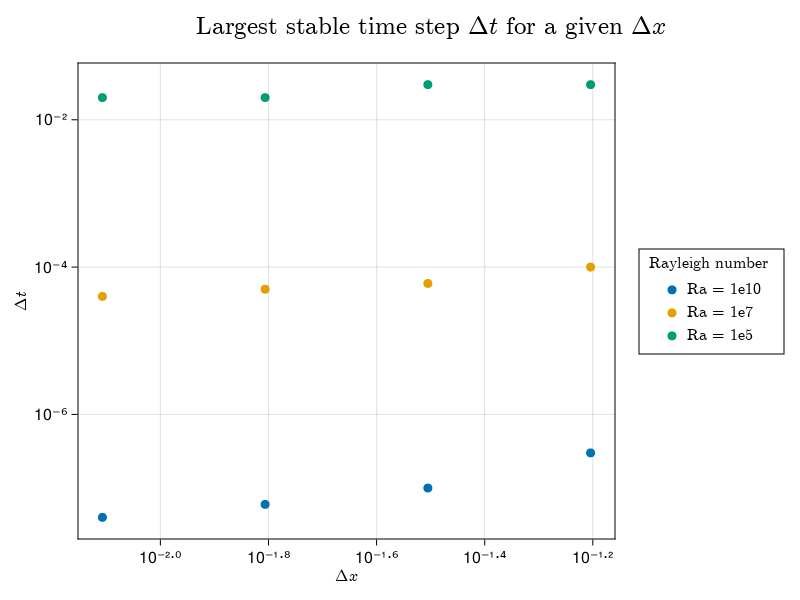

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000024b9fe90, 600.0, 450.0, IOContext(IOStream(<file /home/jovyan/stabilty_task7.pdf>)))


In [157]:
f = Figure()
ax = Axis(f[1,1],xlabel=L"\Delta x",ylabel=L"\Delta t",yscale=log10,xscale=log10)
dx = [1.0/16,1.0/32,1.0/64,1.0/128]
dt_10 = [3e-7,1e-7,6e-8,4e-8]
dt_7 = [1e-4,6e-5,5e-5,4e-5]
dt_5 = [3e-2,3e-2,2e-2,2e-2]
theo = dx./(2*pi)

CairoMakie.scatter!(ax,dx,dt_10,label = L"Ra = 1e10$$")
CairoMakie.scatter!(ax,dx,dt_7,label = L"Ra = 1e7$$")
CairoMakie.scatter!(ax,dx,dt_5,label = L"Ra = 1e5$$")
#CairoMakie.scatter!(ax,dx,theo,label = L"Theoretical $$")

f[1,2] = Legend(f,ax,L"Rayleigh number $$")
Label(f[0,:],text = L"Largest stable time step $\Delta t$ for a given $\Delta x$", textsize = 25)
resize_to_layout!(f)

display(f)
save("stabilty_task7.pdf",f)



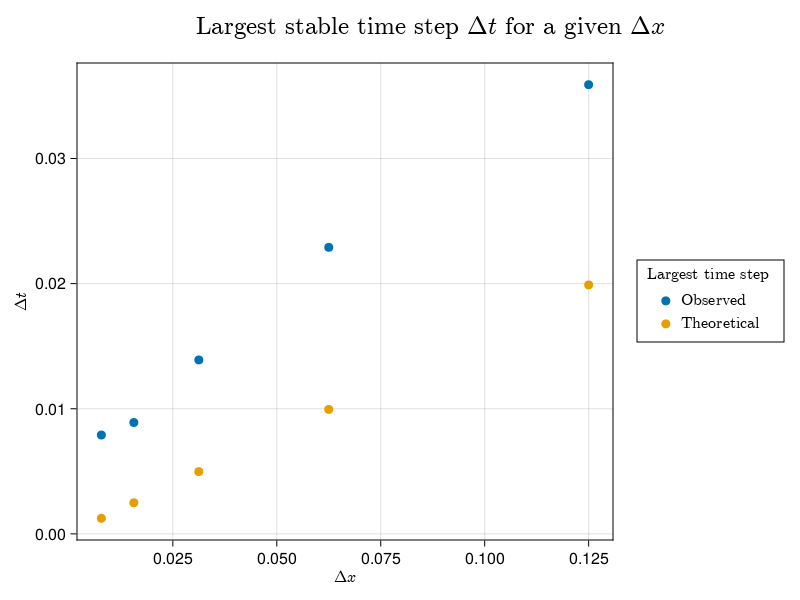

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000056d415d0, 600.0, 450.0, IOContext(IOStream(<file /home/jovyan/stabilty_task4.pdf>)))


In [103]:
f = Figure()
ax = Axis(f[1,1],xlabel=L"\Delta x",ylabel=L"\Delta t")
dx = [1.0/8,1.0/16,1.0/32,1.0/64,1.0/128]
dt = [0.0359,0.0229,0.0139,0.0089,0.0079]
theo = dx./(2*pi)

CairoMakie.scatter!(ax,dx,dt,label = L"Observed $$")
CairoMakie.scatter!(ax,dx,theo,label = L"Theoretical $$")

f[1,2] = Legend(f,ax,L"Largest time step $$")
Label(f[0,:],text = L"Largest stable time step $\Delta t$ for a given $\Delta x$", textsize = 25)
resize_to_layout!(f)

display(f)
save("stabilty_task4.pdf",f)


┌ Info: Saved animation to 
│   fn = /home/jovyan/tmp.gif
└ @ Plots /opt/julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/jovyan/tmp.gif")
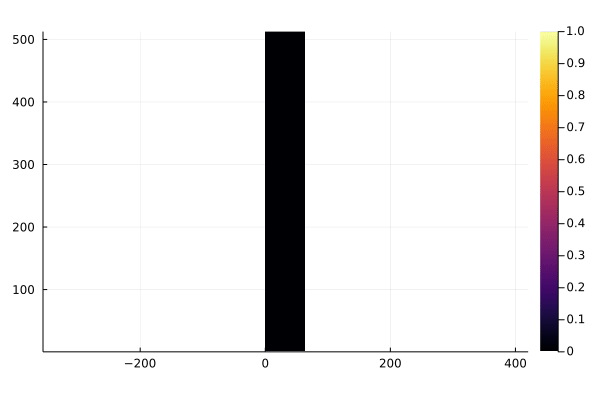

In [16]:
@gif for i in Ts
    heatmap(real(ifft(i)'),aspect_ratio=:equal)
end


In [45]:
Matrix{Vector{Float64}}(undef, Nx, Ny)


LoadError: TypeError: in Type, in parameter, expected Type, got a value of type Matrix{Float64}

LoadError: syntax: more than one semicolon in argument list around In[17]:1

In [160]:
Nx = 32
Ny = 32
Lx = 1.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 0.001
steps = 400



400

In [94]:
T = Matrix{Float64}(undef, 3,3)
T = [1 2 3 ; 4 5 6 ; 7 8 9]
a = [1,2,3]

mapslices(sum ,T', dims=[1])
y = hcat((eachcol(T) .* a)...)
x = hcat((eachrow(T) .* a)...)'
y


3×3 Matrix{Int64}:
 1   4   9
 4  10  18
 7  16  27